<a href="https://colab.research.google.com/github/MADS-Capstone-BLS-Job-Descriptions/predicting_demographics/blob/main/tf_image_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [131]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json

from PIL import Image
from tqdm import tqdm

`https://www.tensorflow.org/tutorials/text/image_captioning`

### **Download and prepare the MS-COCO dataset**
Use the MS-COCO dataset to train your model. The dataset contains over 82,000 images, each of which has at least 5 different caption annotations. The code below downloads and extracts the dataset automatically.

In [7]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

In [8]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [9]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

In [12]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.
train_image_paths = image_paths[:6000]
print(len(train_image_paths))

6000


In [13]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

<start> a man stands in front of an elephant in a cage <end>


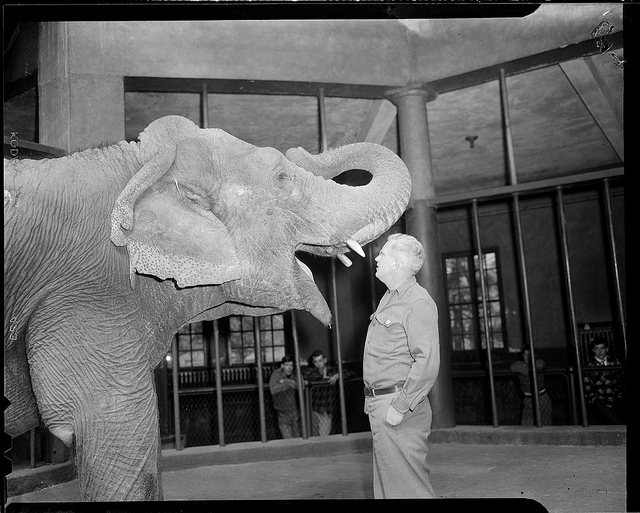

In [14]:
print(train_captions[0])
Image.open(img_name_vector[0])

## **Preprocess the images using InceptionV3**

Next, you will use InceptionV3 (which is pretrained on Imagenet) to classify each image. You will extract features from the last convolutional layer.

First, you will convert the images into InceptionV3's expected format by:

*   Resizing the image to 299px by 299px
*   Preprocess the images using the preprocess_input method to normalize the image so that it contains pixels in the range of -1 to 1, which matches the format of the images used to train InceptionV3.

In [15]:
# 
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## **Initialize InceptionV3 and load the pretrained Imagenet weights**
Now you'll create a tf.keras model where the output layer is the last convolutional layer in the InceptionV3 architecture. The shape of the output of this layer is 8x8x2048. You use the last convolutional layer because you are using attention in this example. You don't perform this initialization during training because it could become a bottleneck.

You forward each image through the network and store the resulting vector in a dictionary (image_name --> feature_vector).
After all the images are passed through the network, you save the dictionary to disk.

In [16]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 1s 0us/step


# **Caching the features extracted from InceptionV3**

You will pre-process each image with InceptionV3 and cache the output to disk. Caching the output in RAM would be faster but also memory intensive, requiring 8 * 8 * 2048 floats per image. At the time of writing, this exceeds the memory limitations of Colab (currently 12GB of memory).

Performance could be improved with a more sophisticated caching strategy (for example, by sharding the images to reduce random access disk I/O), but that would require more code.

The caching will take about 10 minutes to run in Colab with a GPU. If you'd like to see a progress bar, you can:

1.   Install tqdm: !pip install tqdm
2.   Import tqdm: from tqdm import tqdm
3.   Change the following line:

for img, path in image_dataset:

to:

for img, path in tqdm(image_dataset):

In [17]:
!pip install tqdm
from tqdm import tqdm

In [18]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████| 375/375 [21:42<00:00,  3.47s/it]


# **Preprocess and tokenize the captions**
First, you'll tokenize the captions (for example, by splitting on spaces). This gives us a vocabulary of all of the unique words in the data (for example, "surfing", "football", and so on).

Next, you'll limit the vocabulary size to the top 5,000 words (to save memory). You'll replace all other words with the token "UNK" (unknown).
You then create word-to-index and index-to-word mappings.

Finally, you pad all sequences to be the same length as the longest one.

In [19]:
# Find the maximum length of any caption in the dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [20]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
tokenizer.fit_on_texts(train_captions)

In [21]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [22]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [24]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [25]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

# **Split the data into training and testing**

In [26]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [27]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24012, 24012, 6003, 6003)

# **Create a tf.data dataset for training**
Your images and captions are ready! Next, let's create a tf.data dataset to use for training your model.

In [28]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE

# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [29]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [30]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# **Model**
Fun fact: the decoder below is identical to the one in the example for Neural Machine Translation with Attention.

The model architecture is inspired by the Show, Attend and Tell paper.

 
*  In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).

*  You squash that to a shape of (64, 2048).

*  This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).

*  The RNN (here GRU) attends over the image to predict the next word.

In [31]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [32]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [33]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [34]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [35]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

# **Checkpoint**

In [36]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [37]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

# **Training**

*  You extract the features stored in the respective .npy files and then pass those features through the encoder.
*  The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
*  The decoder returns the predictions and the decoder hidden state.
*  The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
*  Use teacher forcing to decide the next input to the decoder.
*  Teacher forcing is the technique where the target word is passed as the next input to the decoder.
*  The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [38]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [39]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [40]:
EPOCHS = 5

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 1.9806
Epoch 1 Batch 100 Loss 1.1925
Epoch 1 Batch 200 Loss 1.0539
Epoch 1 Batch 300 Loss 0.9047
Epoch 1 Loss 1.031424
Time taken for 1 epoch 2112.75 sec

Epoch 2 Batch 0 Loss 0.8829
Epoch 2 Batch 100 Loss 0.7495
Epoch 2 Batch 200 Loss 0.8088
Epoch 2 Batch 300 Loss 0.7216
Epoch 2 Loss 0.780140
Time taken for 1 epoch 2004.73 sec

Epoch 3 Batch 0 Loss 0.8019
Epoch 3 Batch 100 Loss 0.7164
Epoch 3 Batch 200 Loss 0.7011
Epoch 3 Batch 300 Loss 0.6836
Epoch 3 Loss 0.700916
Time taken for 1 epoch 2006.45 sec

Epoch 4 Batch 0 Loss 0.7242
Epoch 4 Batch 100 Loss 0.6161
Epoch 4 Batch 200 Loss 0.6899
Epoch 4 Batch 300 Loss 0.6710
Epoch 4 Loss 0.652339
Time taken for 1 epoch 2001.59 sec

Epoch 5 Batch 0 Loss 0.7451
Epoch 5 Batch 100 Loss 0.6283
Epoch 5 Batch 200 Loss 0.5741
Epoch 5 Batch 300 Loss 0.5924
Epoch 5 Loss 0.615375
Time taken for 1 epoch 2001.59 sec



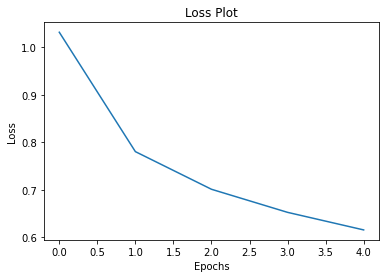

In [41]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

# **Caption!**
*  The evaluate function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
*  Stop predicting when the model predicts the end token.
*  And store the attention weights for every time step.

In [42]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [44]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> a cow grazing in a field with mountain on the horizon <end>
Prediction Caption: a herd of cows that are walking down a dirt <end>


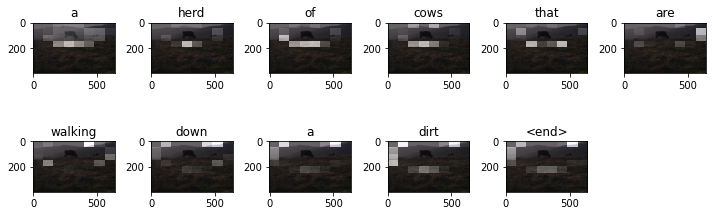

In [45]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i]
                        for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

# **Try it on your own images**
For fun, below you're provided a method you can use to caption your own images with the model you've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for weird results!)

65536/64400 [==============================] - 0s 0us/step
Prediction Caption: a boy on a surf board out of some red frisbee <end>


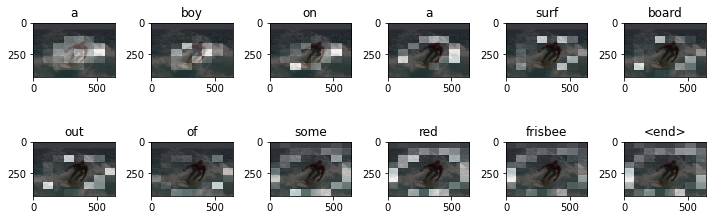

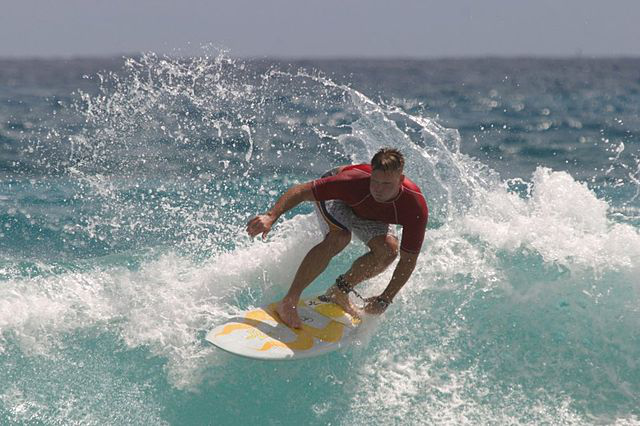

In [46]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)

result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

In [11]:
from google.colab import drive
drive.mount("/gdrive")

Mounted at /gdrive


In [269]:
pwd

'/'

In [13]:
ls

bin/          datalab/  home/   media/  root/  sys/                usr/
boot/         dev/      lib/    mnt/    run/   tensorflow-1.15.2/  var/
captions.pkl  etc/      lib32/  opt/    sbin/  tmp/
content/      gdrive/   lib64/  proc/   srv/   tools/


In [14]:
cd gdrive

/gdrive


In [15]:
ls

MyDrive/  Shareddrives/


In [20]:
cd gdrive/Shareddrives/

/gdrive/Shareddrives


In [22]:
ls

In [25]:
cd /gdrive/My Drive/SIADS_697_698_alanfeh_gpthio_nalurris

/gdrive/My Drive/SIADS_697_698_alanfeh_gpthio_nalurris


In [26]:
ls

captions/  img/  output.txt  SIADS_697-698_Standup1_Script.gdoc


In [27]:
cd captions

/gdrive/My Drive/SIADS_697_698_alanfeh_gpthio_nalurris/captions


In [28]:
ls

captions.pkl


In [298]:
ls

captions/  img/  output.txt  SIADS_697-698_Standup1_Script.gdoc


# **Create nested dictionaries with generated captions for each job in each OOH category**


In [348]:
ooh_categories = []

folder_path = "/gdrive/MyDrive/SIADS_697_698_alanfeh_gpthio_nalurris/img"
for folder in os.listdir(folder_path):
  ooh_categories.append(folder)
ooh_categories = sorted(ooh_categories)
ooh_categories

['architecture_and_engineering',
 'arts_and_design',
 'building_and_grounds_cleaning',
 'business_and_financial',
 'community_and_social _service',
 'computer_and_information_technology',
 'construction_and_extraction',
 'education_training_and_library',
 'entertainment_and_sports',
 'farming_fishing_and_forestry',
 'food_preparation_and_serving',
 'healthcare',
 'installation_maintenance_repair',
 'legal_occupations',
 'life_physical_and_social_science',
 'management',
 'math',
 'media_and_communication',
 'military',
 'office_and_administrative_support',
 'personal_care_and_service',
 'production',
 'protective_service',
 'sales',
 'transportation_and_material_moving']

In [333]:
ooh_categories = []
ooh_jobs = []

folder_path = "/gdrive/MyDrive/SIADS_697_698_alanfeh_gpthio_nalurris/img"
for folder in os.listdir(folder_path):
  ooh_categories.append(folder)
  ooh_categories = sorted(ooh_categories)

  sub_folder_path = os.path.join(folder_path, folder)
  for job in os.listdir(sub_folder_path):
    ooh_jobs.append(job)

In [383]:
# Set Gdrive path
folder_path = "/gdrive/MyDrive/SIADS_697_698_alanfeh_gpthio_nalurris/img"

# Create list of OOH job categories
ooh_categories = []
for folder in os.listdir(folder_path):
  ooh_categories.append(folder)
ooh_categories = sorted(ooh_categories)
ooh_categories

['architecture_and_engineering',
 'arts_and_design',
 'building_and_grounds_cleaning',
 'business_and_financial',
 'community_and_social _service',
 'computer_and_information_technology',
 'construction_and_extraction',
 'education_training_and_library',
 'entertainment_and_sports',
 'farming_fishing_and_forestry',
 'food_preparation_and_serving',
 'healthcare',
 'installation_maintenance_repair',
 'legal_occupations',
 'life_physical_and_social_science',
 'management',
 'math',
 'media_and_communication',
 'military',
 'office_and_administrative_support',
 'personal_care_and_service',
 'production',
 'protective_service',
 'sales',
 'transportation_and_material_moving']

In [388]:
len(ooh_categories)

25

In [ ]:
# Create empty dict with keys
category_dict = dict.fromkeys(ooh_categories, None)

# Loop through categories
for category in tqdm(ooh_categories):
  sub_folder_path = os.path.join(folder_path, category)
  # print(sub_folder_path)

  # Create dict with job image fileames as keys and captions as values
  jobs = []  
  captions = []

  for job_img in os.listdir(sub_folder_path):   
    jobs.append(job_img)
    file_path = os.path.join(sub_folder_path, job_img)
    # print(file_path)

    result, attention_plot = evaluate(file_path)
    caption = " ".join(result)
    # print(caption)
    captions.append(caption)

    job_dict = dict(zip(jobs, captions))
    # job_dict_list.append(job_dict)
    
  category_dict[category] = job_dict

In [394]:
category_dict

{'architecture_and_engineering': {'Aerospace_Engineering_and_Operations_Technicians.jpeg': 'a lady sitting in a chair while boots and vest and phone while wading through the middle of a man <end>',
  'Aerospace_Engineers.jpeg': 'a young girl is blowing the sunshine with a tie with a woman smiling and white <end>',
  'Agricultural_Engineers.jpeg': 'a man with a suit and an antique men and crowd of others restored officers <end>',
  'Architects.jpeg': "a man who is he's lit up on through an elephant at their belongings in the camera while riding an adult trunks paying attention to each other carriage with several elephants stand by a store room <end>",
  'Bioengineers_and_Biomedical_Engineers.jpeg': 'a man is standing in a man <end>',
  'Cartographers_and_Photogrammetrists.jpeg': 'a man is smiling two people standing in a red bear <end>',
  'Chemical_Engineers.jpeg': 'two people stand and a picture around a well pose to a <unk> \n <end>',
  'Civil_Engineering_Technologists_and_Technician

In [119]:
cd captions

/gdrive/MyDrive/SIADS_697_698_alanfeh_gpthio_nalurris/captions


In [9]:
# Save dictionary as pkl file
import pickle

with open('captions.pkl', 'wb') as output:
     pickle.dump(category_dict, output) 

In [140]:
with open('captions.pkl', 'rb') as input:
     caption_dict = pickle.load(input)
caption_dict

{'architecture_and_engineering': {'Aerospace_Engineering_and_Operations_Technicians.jpeg': 'a lady sitting in a chair while boots and vest and phone while wading through the middle of a man <end>',
  'Aerospace_Engineers.jpeg': 'a young girl is blowing the sunshine with a tie with a woman smiling and white <end>',
  'Agricultural_Engineers.jpeg': 'a man with a suit and an antique men and crowd of others restored officers <end>',
  'Architects.jpeg': "a man who is he's lit up on through an elephant at their belongings in the camera while riding an adult trunks paying attention to each other carriage with several elephants stand by a store room <end>",
  'Bioengineers_and_Biomedical_Engineers.jpeg': 'a man is standing in a man <end>',
  'Cartographers_and_Photogrammetrists.jpeg': 'a man is smiling two people standing in a red bear <end>',
  'Chemical_Engineers.jpeg': 'two people stand and a picture around a well pose to a <unk> \n <end>',
  'Civil_Engineering_Technologists_and_Technician

# **Create dataframe with categories, jobs, images and caoptions**

In [141]:
import pandas as pd

cat_job = list()
job_cap = list()

for k1, v1 in caption_dict.items():
  for k2, v2 in v1.items():
    cat_job.append((k1, k2))
    job_cap.append((k2, v2))

cat = []
job = []
cap = []

for i in range(len(cat_job)):
  cat.append(cat_job[i][0])
  job.append(cat_job[i][1])
  cap.append(job_cap[i][1])

caption_df = pd.DataFrame(
    {"Category": cat,
     "Job": job,
     "Caption": cap
     }
     )

caption_df                  

,Category,Job,Caption
0,architecture_and_engineering,Computer_Hardware_Engineers.jpeg,man riding a clock in a fan <end>
1,architecture_and_engineering,Health_and_Safety_Engineers.jpeg,a couple of people walking behind herself to her back talking on her head waiting <end>
2,architecture_and_engineering,Mining_and_Geological_Engineers.jpeg,a man get a man <end>
3,architecture_and_engineering,Surveying_and_Mapping_Technicians.jpeg,a person riding a man riding down a sunny day <end>
4,architecture_and_engineering,Aerospace_Engineers.jpeg,a young girl is blowing the sunshine with a tie with a woman smiling and white <end>
...,...,...,...
292,transportation_and_material_moving,Flight_Attendants.jpeg,a man and smiling <unk> <end>
293,transportation_and_material_moving,Airline_and_Commercial_Pilots.jpeg,a group of women in the baby and skinny carriage walking along <end>
294,transportation_and_material_moving,Heavy_and_Tractor-trailer_Truck_Drivers.jpeg,someone carry letters a suit strapped down a road <end>
295,transportation_and_material_moving,Railroad_Workers.jpeg,two people are featured in a red and train suitcase next to daisies in a secluded area with a very city area <end>


In [142]:
caption_df ["Job"] = caption_df ["Job"].str.replace(r'.jpeg$', '')
caption_df ["Caption"] = caption_df ["Caption"].str.replace(r'<end>', '')
caption_df ["Caption"] = caption_df ["Caption"].str.replace(r'<unk>', '')
caption_df

,Category,Job,Caption
0,architecture_and_engineering,Computer_Hardware_Engineers,man riding a clock in a fan
1,architecture_and_engineering,Health_and_Safety_Engineers,a couple of people walking behind herself to her back talking on her head waiting
2,architecture_and_engineering,Mining_and_Geological_Engineers,a man get a man
3,architecture_and_engineering,Surveying_and_Mapping_Technicians,a person riding a man riding down a sunny day
4,architecture_and_engineering,Aerospace_Engineers,a young girl is blowing the sunshine with a tie with a woman smiling and white
...,...,...,...
292,transportation_and_material_moving,Flight_Attendants,a man and smiling
293,transportation_and_material_moving,Airline_and_Commercial_Pilots,a group of women in the baby and skinny carriage walking along
294,transportation_and_material_moving,Heavy_and_Tractor-trailer_Truck_Drivers,someone carry letters a suit strapped down a road
295,transportation_and_material_moving,Railroad_Workers,two people are featured in a red and train suitcase next to daisies in a secluded area with a very city area


In [143]:
caption_df = caption_df.sort_values(["Category", "Job"], ascending=[True, True])
caption_df

,Category,Job,Caption
15,architecture_and_engineering,Aerospace_Engineering_and_Operations_Technicians,a lady sitting in a chair while boots and vest and phone while wading through the middle of a man
4,architecture_and_engineering,Aerospace_Engineers,a young girl is blowing the sunshine with a tie with a woman smiling and white
26,architecture_and_engineering,Agricultural_Engineers,a man with a suit and an antique men and crowd of others restored officers
17,architecture_and_engineering,Architects,a man who is he's lit up on through an elephant at their belongings in the camera while riding an adult trunks paying attention to each other carriage with several elephants stand by a store room
8,architecture_and_engineering,Bioengineers_and_Biomedical_Engineers,a man is standing in a man
...,...,...,...
294,transportation_and_material_moving,Heavy_and_Tractor-trailer_Truck_Drivers,someone carry letters a suit strapped down a road
287,transportation_and_material_moving,Material_Moving_Machine_Operators,a man in a hat and guitar
291,transportation_and_material_moving,Passenger_Vehicle_Drivers,there is a bus stopped at a light with a building with umbrellas
295,transportation_and_material_moving,Railroad_Workers,two people are featured in a red and train suitcase next to daisies in a secluded area with a very city area


In [144]:
# Save df as pkl file
with open('caption_df.pkl', 'wb') as output:
  pickle.dump(caption_df, output) 

In [161]:
# Embed PIL.Image objects in df
path = "/gdrive/MyDrive/SIADS_697_698_alanfeh_gpthio_nalurris/img"

caption_df["Image"] = None

def get_thumbnail(path):
  i = Image.open(path)
  i.thumbnail((150, 150), Image.LANCZOS)
  return i

for i in tqdm(range(len(caption_df))):
  sub_folder_path = os.path.join(path, caption_df["Category"].iloc[i], caption_df["Job"].iloc[i] + ".jpeg")
  caption_df["Image"].iloc[i] = get_thumbnail(sub_folder_path)

# caption_df = caption_df[["Image", "Caption", "Job", "Category"]]

# Can't get images to render so omit for now
caption_df = caption_df[["Category", "Job", "Caption"]]
caption_df

100%|██████████| 297/297 [00:00<00:00, 558.96it/s]


,Category,Job,Caption
15,architecture_and_engineering,Aerospace_Engineering_and_Operations_Technicians,a lady sitting in a chair while boots and vest and phone while wading through the middle of a man
4,architecture_and_engineering,Aerospace_Engineers,a young girl is blowing the sunshine with a tie with a woman smiling and white
26,architecture_and_engineering,Agricultural_Engineers,a man with a suit and an antique men and crowd of others restored officers
17,architecture_and_engineering,Architects,a man who is he's lit up on through an elephant at their belongings in the camera while riding an adult trunks paying attention to each other carriage with several elephants stand by a store room
8,architecture_and_engineering,Bioengineers_and_Biomedical_Engineers,a man is standing in a man
...,...,...,...
294,transportation_and_material_moving,Heavy_and_Tractor-trailer_Truck_Drivers,someone carry letters a suit strapped down a road
287,transportation_and_material_moving,Material_Moving_Machine_Operators,a man in a hat and guitar
291,transportation_and_material_moving,Passenger_Vehicle_Drivers,there is a bus stopped at a light with a building with umbrellas
295,transportation_and_material_moving,Railroad_Workers,two people are featured in a red and train suitcase next to daisies in a secluded area with a very city area


In [169]:
# Save df as pkl file
with open('caption_df_no_img.pkl', 'wb') as output:
  pickle.dump(caption_df, output) 

In [162]:
# Display PIL.Image objects embedded in df
# from IPython.display import HTML, IFrame

# HTML(caption_df[["Image", "Caption", "Job", "Category"]].to_html(escape=False))

In [163]:
# This code works to create list of rendered images
# image_list = []
# im1 = plt.imread('Aerospace_Engineering_and_Operations_Technicians.jpeg')
# plt.imshow(im1)
# a = plt.show()
# image_list.append(a)

# im2 = plt.imread('Aerospace_Engineers.jpeg')
# plt.imshow(im2)
# b = plt.show()
# image_list.append(b)

# type(image_list)

In [423]:
cat = []
job = []

for i in range(len(cat_job)):
  cat.append(cat_job[i][0])
  job.append(cat_job[i][1])

print(len(cat), len(job))

297 297


In [164]:
# To load files from local drive
# from google.colab import files
# uploaded = files.upload()

In [165]:
# test_image = "Surveyors.jpeg"
# Image.open(test_image)

In [362]:
# Get prediction for all images
import glob
from PIL import Image

test_images = glob.glob("/content/img/architecture_and_engineering/*.jpeg")

for i in range(len(test_images)):
  print(test_images[i])
  result, attention_plot = evaluate(test_images[i])
  print("Prediction Caption:", " ".join(result))
  Image.open(test_images[i])
  print()

Mining_and_Geological_Engineers.jpeg


NotFoundError: ignored

In [168]:
dir = "/gdrive/MyDrive/SIADS_697_698_alanfeh_gpthio_nalurris/img/architecture_and_engineering/"

for filename in os.listdir(dir):
  print(filename)
  if filename.endswith(".jpeg"):
    result, attention_plot = evaluate(filename)
    image = Image.open(dir + '/' + filename)
    print("Prediction Caption:", " ".join(result))
    Image.open(ima)
    print()

Computer_Hardware_Engineers.jpeg


NameError: ignored